In [56]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from pylab import rcParams
rcParams['figure.figsize'] = (9,6.75)
stock = 'JNJ'
source = 'yahoo'
start = datetime(2019,1,1)
end = datetime.today()
df = web.DataReader(stock, source, start, end)
ts = df['Median'] = (df['High'] - df['Low']) * 0.5 + df['Low']
for col in df.columns:
    df[col] = np.round(df[col], 2)

In [114]:
def test_stationarity(ts, window=12, cutoff=0.05):
    global rolmean
    rolmean = ts.rolling(window).mean()
    rolstd = ts.rolling(window).std()
    plt.plot(ts, label='Existing Timeseries')
    plt.plot(rolmean, label='Rolling Mean')
    plt.plot(rolstd, label='Rolling Standard Deviation')
    plt.legend(loc="center")
    plt.title("Stationarity Test")
    plt.show(block=False)
    adft = adfuller(ts, autolag='AIC')
    output = pd.Series(adft[0:4], index=['Test Statistics', 'P-Value', '# Lags', '# Observations'])
    p_value = adft[1]
    if p_value < cutoff:
        print('P-Value = %.4f. The series is likely stationary.' % p_value)
    else:
        print('P-Value = %.4f. The series is likely non-stationary.' % p_value)
    print("\n")
    for key, value in adft[4].items():
        output['critical value (%s)' % key] = value
    print(output)

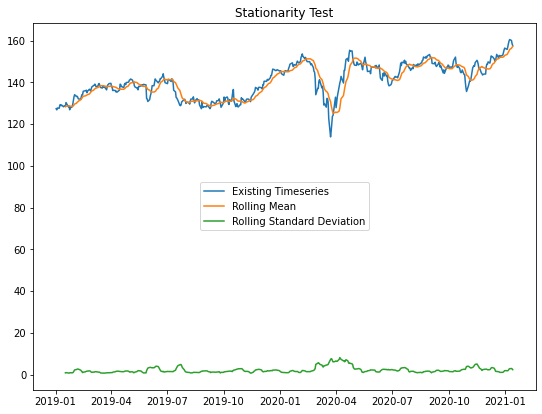

P-Value = 0.0781. The series is likely non-stationary.


Test Statistics          -2.677223
P-Value                   0.078063
# Lags                    9.000000
# Observations          503.000000
critical value (1%)      -3.443418
critical value (5%)      -2.867303
critical value (10%)     -2.569840
dtype: float64


In [115]:
test_stationarity(ts)

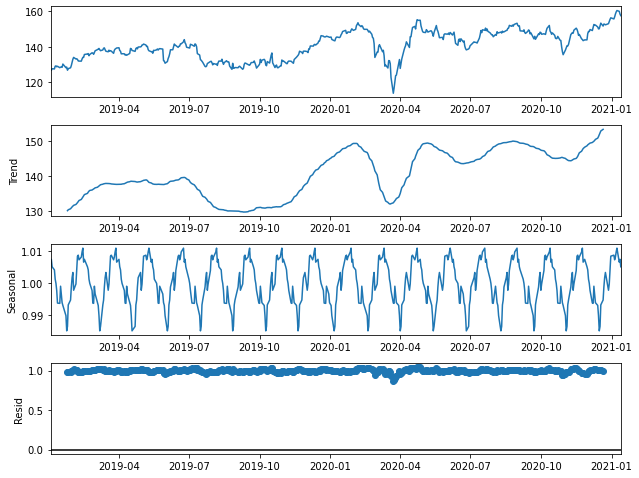

In [116]:
sd = seasonal_decompose(ts, model='multiplicative', period=30)
sd.plot()
plt.show()

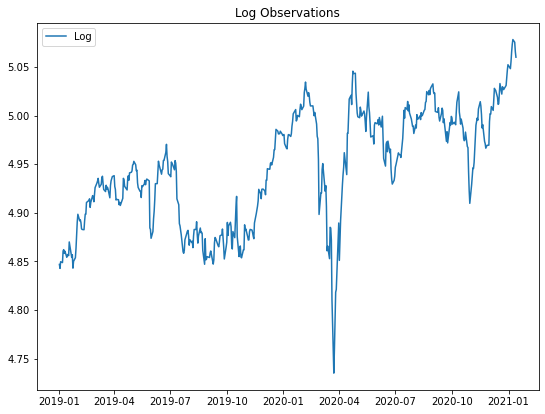

In [117]:
df_log = np.log(ts)
plt.title("Log Observations")
plt.plot(df_log, label='Log')
plt.legend()
plt.show()

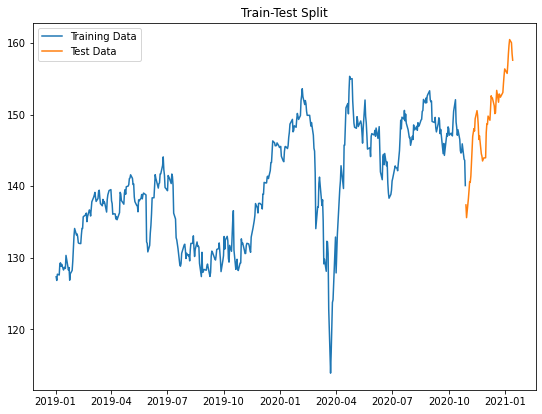

In [118]:
split = int(len(ts) * 0.9)
train, test = ts[:split], ts[split:]
plt.title("Train-Test Split")
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.legend()
plt.show()

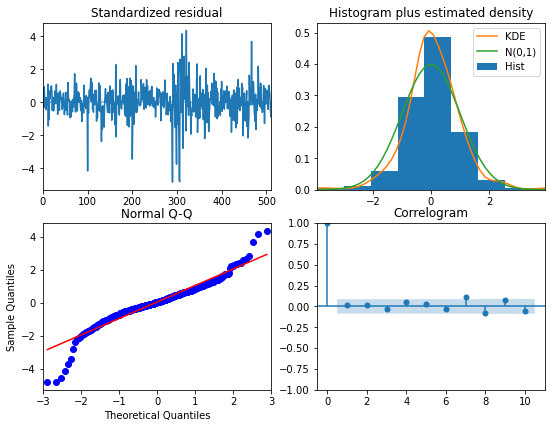

In [119]:
import warnings
warnings.filterwarnings('ignore')
aa = auto_arima(ts)
aa.plot_diagnostics()
plt.show()

In [124]:
model = ARIMA(ts, order=(3,1,0)).fit(disp=-1)

tdl = len(test)
dl = []
for x in range(0, tdl):
    dl.append(end + timedelta(days=x))
dl = pd.Series(dl)
dl.index = dl.values

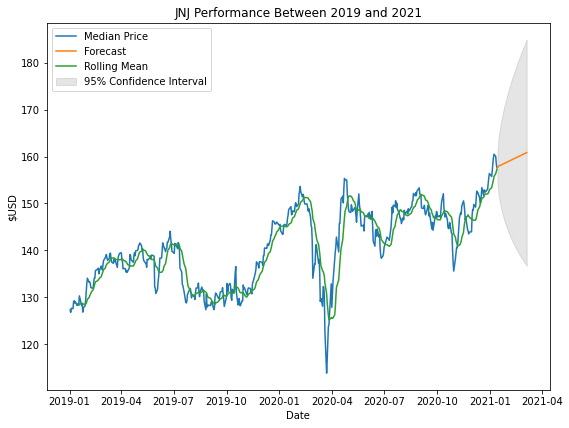

In [125]:
fc, se, conf = model.forecast(tdl, alpha=0.05)
fc = pd.Series(fc, index=dl.index)
fc_diff = ts[-1] - fc[0]
fc = fc + fc_diff
plt.plot(ts, label='Median Price')
plt.plot(fc, label='Forecast')
plt.plot(rolmean, label='Rolling Mean')
lower = conf[:,0] + fc_diff
upper = conf[:,1] + fc_diff
plt.fill_between(dl.index, lower, upper, color='k', alpha=0.1, label='95% Confidence Interval')
plt.legend(loc='upper left')
plt.xlabel("Date")
plt.ylabel("$USD")
sy = str(start.year)
ey = str(end.year)
title = "%s Performance Between %s and %s" % (stock, sy, ey)
plt.title(title)
plt.show()